In [10]:
import numpy as np
from rdkit.Chem import Draw
import mdtraj as md
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
traj1 = md.load(f"../example_data/12384.h5")
traj1.n_frames

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


106

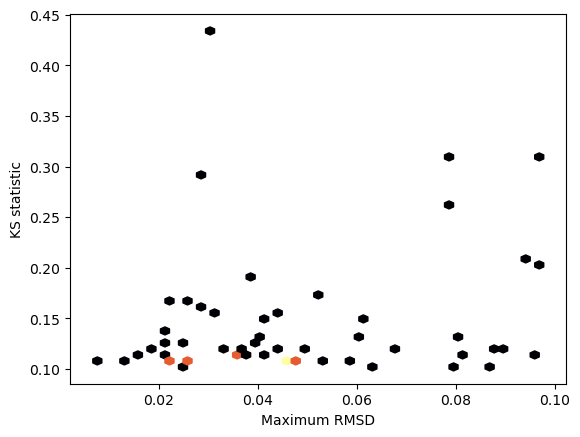

In [22]:
df_rmsd = pd.read_csv("/localhome/cschiebroek/MDFPs/mdfptools/carl/data/distribution_stats/max_rmsds_confs.csv")
df_ks_stats = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/distribution_stats/ks_stat.csv',index_col=0)
df_merged = df_ks_stats.merge(df_rmsd,how='inner',on=['confid1','confid2'])
df_merged_tmp = df_merged[df_merged.max_rmsd < 0.11]
df_merged_tmp_significant = df_merged_tmp[df_merged_tmp.ks_pvals < 0.05]
df_merged_tmp_significant_diff = df_merged_tmp_significant[df_merged_tmp_significant.ks_stat > 0.1]

plt.hexbin(df_merged_tmp_significant_diff.max_rmsd,df_merged_tmp_significant_diff.ks_stat,gridsize=50,bins='log',cmap='inferno',mincnt=1)
plt.xlabel('Maximum RMSD')
plt.ylabel('KS statistic')
plt.show()


In [128]:
df_merged_tmp
#check if 1 in molregno
df_merged_tmp[df_merged_tmp.molregno == 1]

,confid1,confid2,ks_stat,ks_pvals,Unnamed: 0,molregno,max_rmsd
1141,2298,7191,0.038,0.863677,1190,1,0.016077


In [125]:
df_merged_tmp_significant_diff.sort_values(by='ks_stat',ascending=False).head(7)

,confid1,confid2,ks_stat,ks_pvals,Unnamed: 0,molregno,max_rmsd
130,1252,13276,0.434,1.131155e-42,137,107,0.030344
1399,2607,8914,0.310,1.280323e-21,1458,2609,0.078277
2885,4220,6838,0.308,2.423732e-21,3002,4222,0.097750
429,1559,12971,0.290,6.208915e-19,452,414,0.027672
911,5754,5755,0.262,1.718743e-15,952,1057,0.078762
1593,2810,9014,0.208,7.031163e-10,1662,2812,0.094132
1844,3079,11377,0.202,2.445296e-09,1924,3081,0.096885


In [24]:
import psycopg2
from rdkit import Chem
from rdkit.Chem import AllChem
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

RMSD: 1.1165718848323392


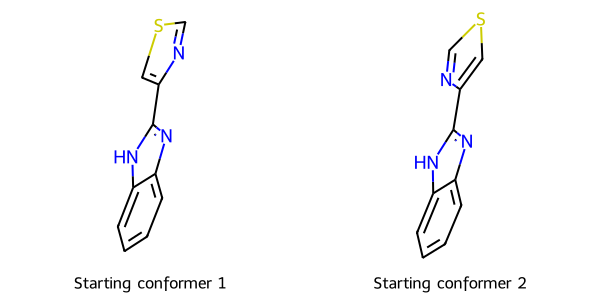

In [37]:
cur.execute(f"SELECT * FROM conformers WHERE conf_id = {1252} OR conf_id = {13276}")
results = cur.fetchall()
results
mols = [Chem.MolFromMolBlock(result[3]) for result in results]
print(f'RMSD: {AllChem.AlignMol(mols[0],mols[1])}')
img = Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
img

Best RMSD: 0.03034396175201957


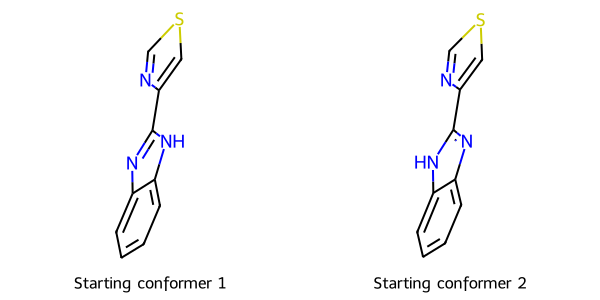

In [38]:
cur.execute(f"SELECT * FROM conformers WHERE conf_id = {1252} OR conf_id = {13276}")
results = cur.fetchall()
results
mols = [Chem.MolFromMolBlock(result[3]) for result in results]
print(f'Best RMSD: {AllChem.GetBestRMS(mols[0],mols[1])}')
img = Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
img

Best RMSD: 0.03034396175201957
Best RMSD: 0.07827671113671428
Best RMSD: 0.09774954261289327
Best RMSD: 0.02767243446717929
Best RMSD: 0.07876215866620834
Best RMSD: 0.09413239894196918
Best RMSD: 0.09688452103839067
Best RMSD: 0.03903222340386533
Best RMSD: 0.05224578416309291
Best RMSD: 0.022797303469500145
[<rdkit.Chem.rdchem.Mol object at 0x7f0072767060>, <rdkit.Chem.rdchem.Mol object at 0x7f0072766ff0>, <rdkit.Chem.rdchem.Mol object at 0x7f0072765f50>, <rdkit.Chem.rdchem.Mol object at 0x7f0072766180>, <rdkit.Chem.rdchem.Mol object at 0x7f0072766110>, <rdkit.Chem.rdchem.Mol object at 0x7f0072766030>, <rdkit.Chem.rdchem.Mol object at 0x7f0072766260>, <rdkit.Chem.rdchem.Mol object at 0x7f0072766500>, <rdkit.Chem.rdchem.Mol object at 0x7f00727661f0>, <rdkit.Chem.rdchem.Mol object at 0x7f00727660a0>, <rdkit.Chem.rdchem.Mol object at 0x7f0072766340>, <rdkit.Chem.rdchem.Mol object at 0x7f0072764ba0>, <rdkit.Chem.rdchem.Mol object at 0x7f00727663b0>, <rdkit.Chem.rdchem.Mol object at 0x7f0

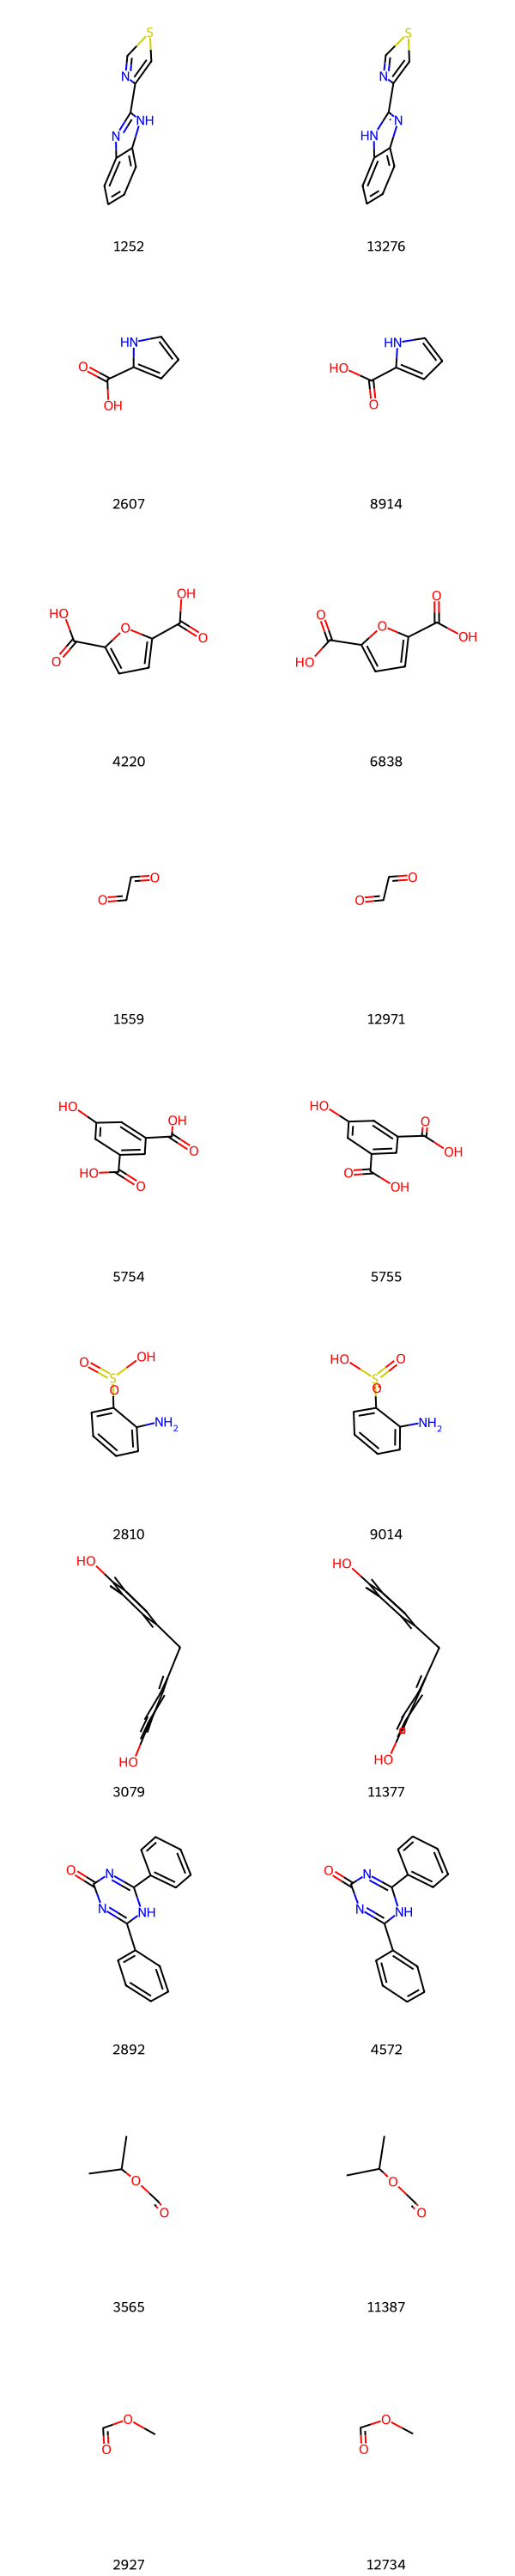

In [68]:
df_top = df_merged_tmp_significant_diff.sort_values(by='ks_stat',ascending=False).head(10)
confid1s,confids2 = df_top.confid1.values,df_top.confid2.values
mols_list =[]
cids = []
for confid1,confid2 in zip(confid1s,confids2):
    cur.execute(f"SELECT * FROM conformers WHERE conf_id = {confid1} OR conf_id = {confid2}")
    results = cur.fetchall()
    mols = [Chem.MolFromMolBlock(result[3]) for result in results]
    print(f'Best RMSD: {AllChem.GetBestRMS(mols[0],mols[1])}')
    mols_list.append(mols)
    cids.append(confid1)
    cids.append(confid2)
mols_list = [mol for mols in mols_list for mol in mols]
print(mols_list)
img = Draw.MolsToGridImage(mols_list,molsPerRow=2,subImgSize=(300,300),legends=[f'{cid}' for cid in cids])
img


Best RMSD: 0.07827671113671428


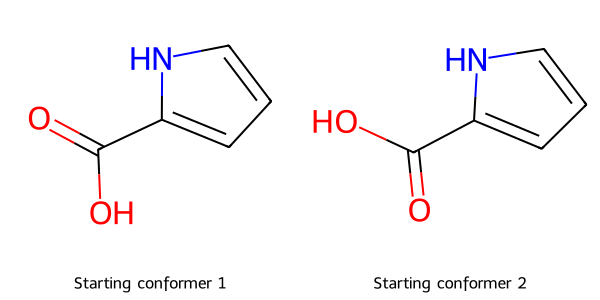

In [56]:
confid1 = 2607	
confid2 = 8914	

cur.execute(f"SELECT * FROM conformers WHERE conf_id = {confid1} OR conf_id = {confid2}")
results = cur.fetchall()
results
mols = [Chem.MolFromMolBlock(result[3]) for result in results]
print(f'Best RMSD: {AllChem.GetBestRMS(mols[0],mols[1])}')
img = Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
img

In [ ]:
#project both onto 2d


Best RMSD: 8.043721791317545


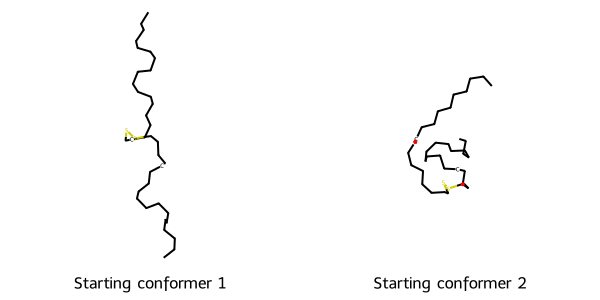

In [39]:
confid1 = 2361
confid2= 7712
cur.execute(f"SELECT * FROM conformers WHERE conf_id = {confid1} OR conf_id = {confid2}")
results = cur.fetchall()
results
mols = [Chem.MolFromMolBlock(result[3]) for result in results]
print(f'Best RMSD: {AllChem.GetBestRMS(mols[0],mols[1])}')
img = Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
img

RMSD: 8.168043362677533


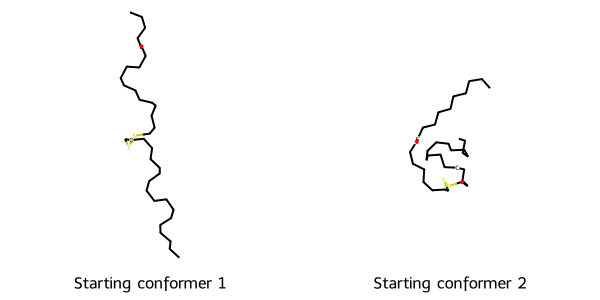

In [40]:
confid1 = 2361
confid2= 7712
cur.execute(f"SELECT * FROM conformers WHERE conf_id = {confid1} OR conf_id = {confid2}")
results = cur.fetchall()
results
mols = [Chem.MolFromMolBlock(result[3]) for result in results]
print(f'RMSD: {AllChem.AlignMol(mols[0],mols[1])}')
img = Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
img

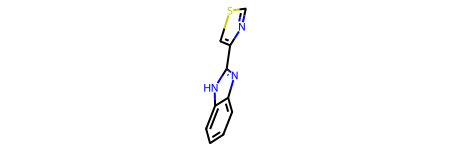

In [27]:
mols[0]

In [31]:
import pickle
top = pickle.load(open('/home/cschiebroek/Downloads/13276.pickle','rb'))
#print type
type(top)
#save parmed.structure.Structure as prmtop
top.save('13276.prmtop')

In [32]:
import pickle
top = pickle.load(open('/home/cschiebroek/Downloads/1252.pickle','rb'))
top.save('/home/cschiebroek/Downloads/1252.prmtop')


In [109]:
import numpy as np
from rdkit.Chem import Draw
import sys
from scipy.stats import ks_2samp

sys.path.append('../')
from Extractor import WaterExtractor
df_max_rmsds_nz = df_rmsd[df_rmsd.max_rmsd != 0]
def check_dists(confid1,confid2,check = False,energy = "water_intra_ene"):
    traj1 = md.load(f"../example_data/{confid1}.h5")
    rdk_pmd1 = pickle.load(open(f"../example_data/{confid1}.pickle", "rb"))

    energie_dict1 = WaterExtractor.extract_energies(mdtraj_obj=traj1,parmed_obj=rdk_pmd1)
    water_total_ene1 = energie_dict1[energy]


    traj2 = md.load(f"../example_data/{confid2}.h5")
    rdk_pmd2 = pickle.load(open(f"../example_data/{confid2}.pickle", "rb"))

    energie_dict2 = WaterExtractor.extract_energies(mdtraj_obj=traj2,parmed_obj=rdk_pmd2)
    water_total_ene2 = energie_dict2[energy]
    ks_statistic, p_value = ks_2samp(water_total_ene1,water_total_ene2)
    print(f'KS statistic: {np.round(ks_statistic,3)} pval: {np.round(p_value,5)}')
    print(f'Conf1 mean: {np.round(np.mean(water_total_ene1),3)} std: {np.round(np.std(water_total_ene1),3)}, Conf1 median: {np.round(np.median(water_total_ene1),3)}, datapoints: {len(water_total_ene1)}')
    print(f'Conf2 mean: {np.round(np.mean(water_total_ene2),3)} std: {np.round(np.std(water_total_ene2),3)}, Conf2 median: {np.round(np.median(water_total_ene2),3)}, datapoints: {len(water_total_ene2)}')

    if check:
        #get vals from df
        df_tmp = df_max_rmsds_nz[(df_max_rmsds_nz.confid1 == confid1) & (df_max_rmsds_nz.confid2 == confid2)]
        #get rmsd
        rmsd = df_tmp.max_rmsd.values[0]
        print('Recorded RMSD: ',rmsd)
        #get ks_stat
        df_tmp = df_ks_stats[(df_ks_stats.confid1 == confid1) & (df_ks_stats.confid2 == confid2)]
        ks_stat = df_tmp.ks_stat.values[0]
        print('Recorded KS statistic: ',ks_stat)

    plt.hist(water_total_ene1,bins='auto',alpha=0.5,label='confid1')
    plt.hist(water_total_ene2,bins='auto',alpha=0.5,label='confid2')
    #set axis titles
    plt.xlabel('Water total energy (kJ/mol)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


    cur.execute(f"SELECT * FROM conformers WHERE conf_id = {confid1} OR conf_id = {confid2}")
    results = cur.fetchall()
    results
    mols = [Chem.MolFromMolBlock(result[3]) for result in results]
    print(f'RMSD: {AllChem.AlignMol(mols[0],mols[1])}')
    print(f'Best RMSD: {AllChem.GetBestRMS(mols[0],mols[1])}')
    img = Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),legends=['Starting conformer 1','Starting conformer 2'])
    return img


KS statistic: 1.0 pval: 0.0
Conf1 mean: 125.38 std: 3.679, Conf1 median: 125.533, datapoints: 500
Conf2 mean: 78.84 std: 2.551, Conf2 median: 78.763, datapoints: 500
Recorded RMSD:  0.0303439617520195
Recorded KS statistic:  0.434
RMSD: 1.1165718848323392
Best RMSD: 0.03034396175247117


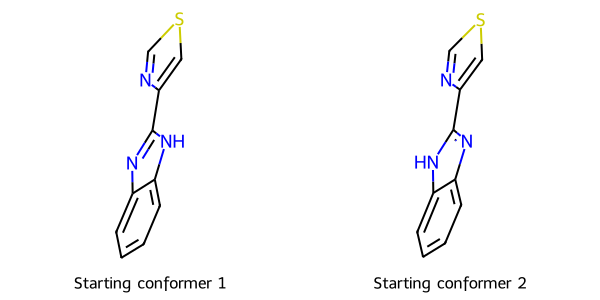

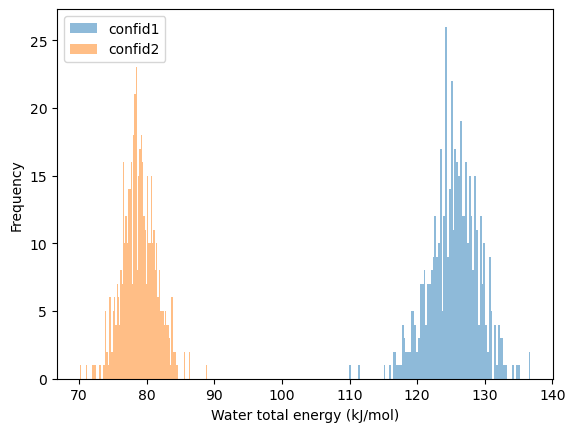

In [55]:
check_dists(1252,13276,check=True)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


KS statistic: 0.042 pval: 0.77044
Conf1 mean: -942.936 std: 6.257, Conf1 median: -943.277, datapoints: 500
Conf2 mean: -943.028 std: 6.104, Conf2 median: -943.362, datapoints: 500
Recorded RMSD:  0.0390322234038653
Recorded KS statistic:  0.192
RMSD: 1.0855646150184048
Best RMSD: 0.03903222340480427


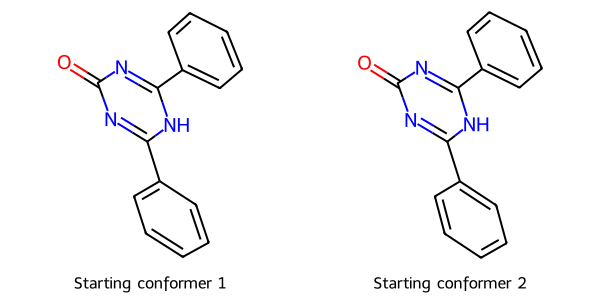

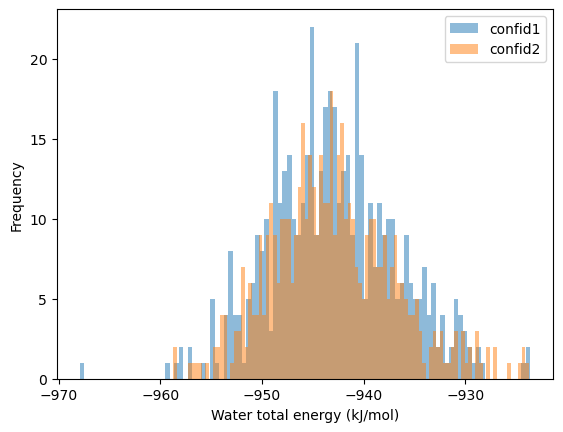

In [72]:
check_dists(2892,4572,check=True)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


KS statistic: 0.192 pval: 0.0
Conf1 mean: -1207.672 std: 23.609, Conf1 median: -1207.242, datapoints: 500
Conf2 mean: -1217.283 std: 22.491, Conf2 median: -1217.611, datapoints: 500
Recorded RMSD:  0.0390322234038653
Recorded KS statistic:  0.192
RMSD: 1.0855646150184048
Best RMSD: 0.03903222340480427


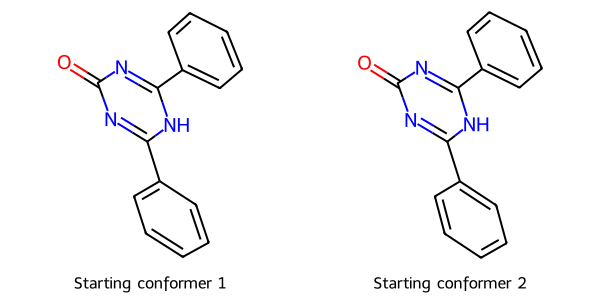

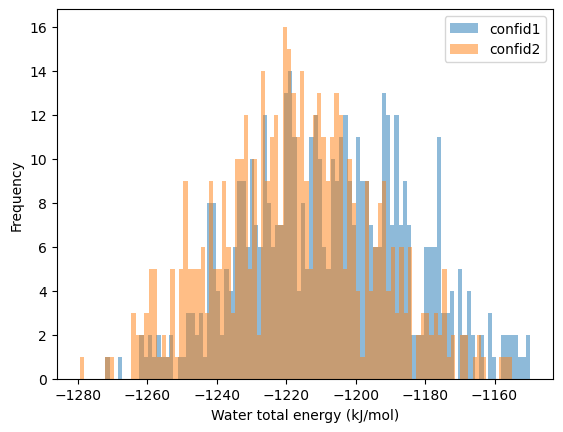

In [73]:
check_dists(2892,4572,check=True,energy='water_total_ene')

In [92]:
for confid1,confid2 in zip(confid1s,confids2):
    print(f'Conformer pair: {confid1} {confid2}')
    
    # try:
    #     print(f'Conformer pair: {confid1} {confid2}')
    #     print('Total energy in water')
    #     check_dists(confid1,confid2,check=True,energy='water_total_ene')
    #     print('Intramolcular energy in water')
    #     check_dists(confid1,confid2,check=True,energy='water_intra_ene')
    #     print('-----------------------------------')
    # except OSError:
    #     print('No file found for ',confid1,confid2)

Conformer pair: 1252 13276
Conformer pair: 2607 8914
Conformer pair: 4220 6838
Conformer pair: 1559 12971
Conformer pair: 5754 5755
Conformer pair: 2810 9014
Conformer pair: 3079 11377
Conformer pair: 2892 4572
Conformer pair: 3565 11387
Conformer pair: 2927 12734


KS statistic: 0.29 pval: 0.0
Conf1 mean: -1.896 std: 11.58, Conf1 median: -1.062, datapoints: 500
Conf2 mean: -11.138 std: 16.223, Conf2 median: -10.921, datapoints: 500
Recorded RMSD:  0.0276724344671792
Recorded KS statistic:  0.29


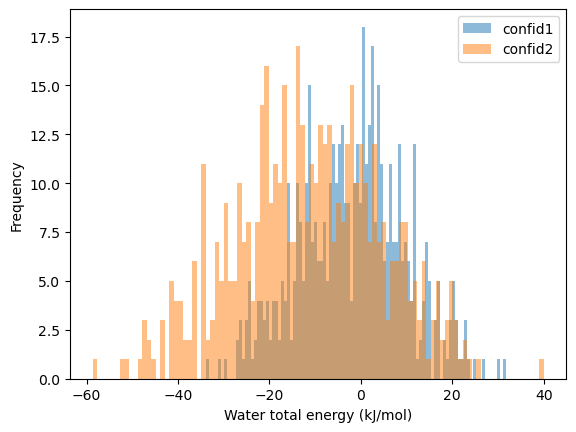

RMSD: 0.02767243446717929
Best RMSD: 0.02767243446715121


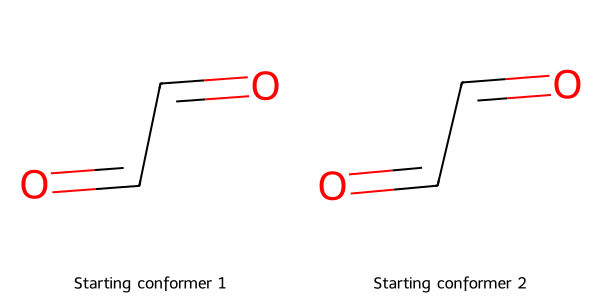

In [81]:
check_dists(1559,12971,check=True,energy='water_total_ene')


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


KS statistic: 0.762 pval: 0.0
Conf1 mean: 73.236 std: 0.926, Conf1 median: 73.213, datapoints: 500
Conf2 mean: 89.618 std: 9.616, Conf2 median: 93.055, datapoints: 500
Recorded RMSD:  0.0276724344671792
Recorded KS statistic:  0.29


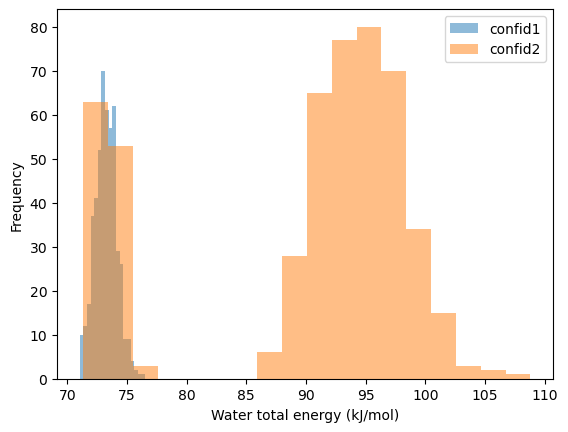

RMSD: 0.02767243446717929
Best RMSD: 0.02767243446715121


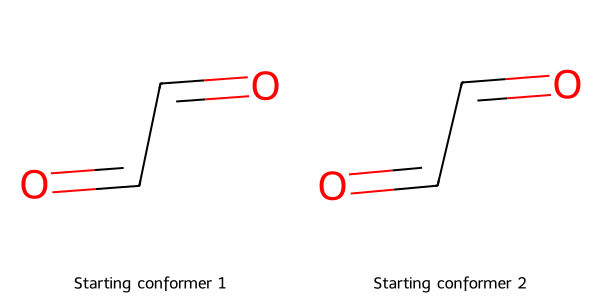

In [110]:
check_dists(1559,12971,check=True,energy='water_intra_ene')


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


KS statistic: 0.042 pval: 0.77044
Conf1 mean: -942.936 std: 6.257, Conf1 median: -943.277, datapoints: 500
Conf2 mean: -943.028 std: 6.104, Conf2 median: -943.362, datapoints: 500
Recorded RMSD:  0.0390322234038653
Recorded KS statistic:  0.192


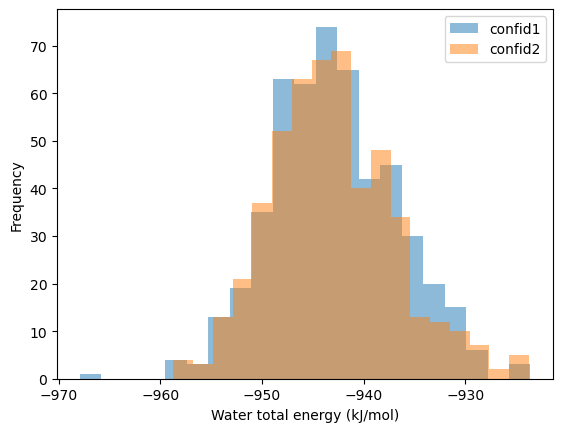

RMSD: 1.0855646150184048
Best RMSD: 0.03903222340480427


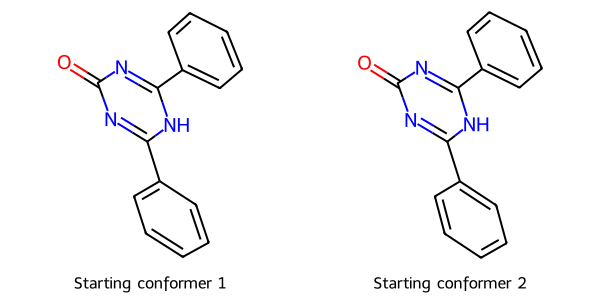

In [123]:
check_dists(2892,4572,check=True,energy='water_intra_ene')


KS statistic: 0.192 pval: 0.0
Conf1 mean: -1207.672 std: 23.609, Conf1 median: -1207.242, datapoints: 500
Conf2 mean: -1217.283 std: 22.491, Conf2 median: -1217.611, datapoints: 500
Recorded RMSD:  0.0390322234038653
Recorded KS statistic:  0.192


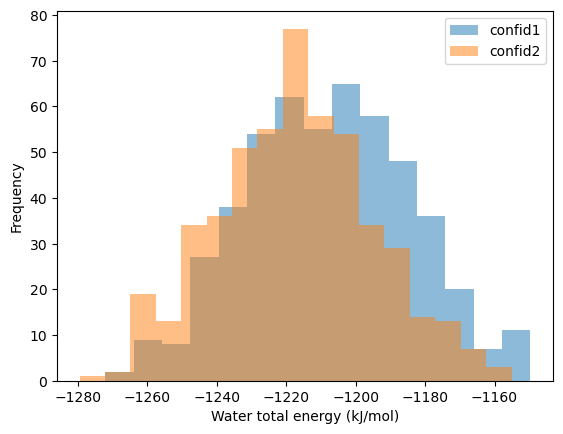

RMSD: 1.0855646150184048
Best RMSD: 0.03903222340480427


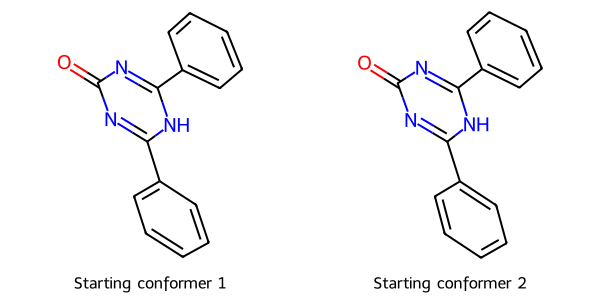

In [124]:
check_dists(2892,4572,check=True,energy='water_total_ene')


In [117]:
#can we look at the velocities? is that in the h5 file?
traj1 = md.load(f"../example_data/1559.h5")

In [122]:
traj1.xyz.shape

(500, 1500, 3)

In [83]:
confid1 = 1559
confid2 = 12971
energy = 'water_intra_ene'
traj1 = md.load(f"../example_data/{confid1}.h5")
rdk_pmd1 = pickle.load(open(f"../example_data/{confid1}.pickle", "rb"))

energie_dict1 = WaterExtractor.extract_energies(mdtraj_obj=traj1,parmed_obj=rdk_pmd1)
water_total_ene1 = energie_dict1[energy]


traj2 = md.load(f"../example_data/{confid2}.h5")
rdk_pmd2 = pickle.load(open(f"../example_data/{confid2}.pickle", "rb"))

energie_dict2 = WaterExtractor.extract_energies(mdtraj_obj=traj2,parmed_obj=rdk_pmd2)
water_total_ene2 = energie_dict2[energy]
ks_statistic, p_value = ks_2samp(water_total_ene1,water_total_ene2)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


500


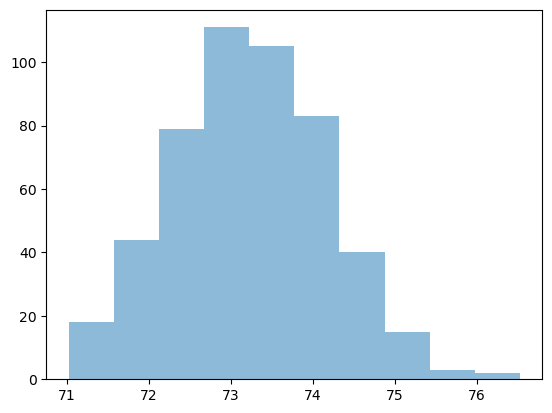

In [106]:
plt.hist(water_total_ene1,bins=10,alpha=0.5,label='confid1')
print(len(water_total_ene1))
plt.show()

500


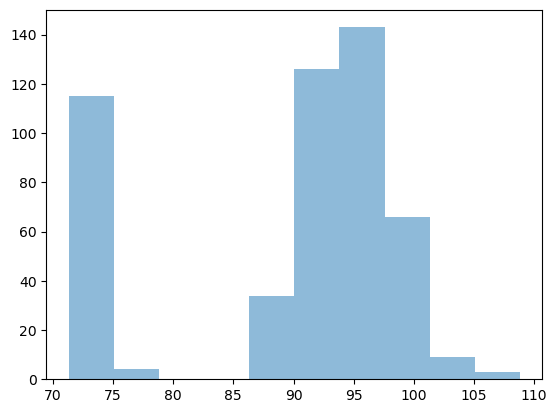

In [108]:
plt.hist(water_total_ene2,bins=10,alpha=0.5,label='confid1')
print(len(water_total_ene2))
plt.show()

In [96]:
for confs in confid1s, confids2:
    for conf in confs:
        print(conf)
        try:
            top = pickle.load(open(f'/home/cschiebroek/Downloads/{conf}.pickle','rb'))
            top.save(f'/home/cschiebroek/Downloads/{conf}.prmtop')
        except FileNotFoundError:
            print('File not found for ',conf)
        except OSError:
            print('File not found for ',conf)

    
# top = pickle.load(open('/home/cschiebroek/Downloads/13276.pickle','rb'))
# #print type
# type(top)
# #save parmed.structure.Structure as prmtop
# top.save('13276.prmtop')

1252
File not found for  1252
2607
File not found for  2607
4220
File not found for  4220
1559
5754
File not found for  5754
2810
File not found for  2810
3079
2892
3565
File not found for  3565
2927
File not found for  2927
13276
8914
File not found for  8914
6838
File not found for  6838
12971
5755
File not found for  5755
9014
File not found for  9014
11377
4572
11387
File not found for  11387
12734
File not found for  12734
